In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)

from pymgrid import Microgrid
from pymgrid.modules import BatteryModule, LoadModule, RenewableModule, GridModule

## Data Visualization

### All Buildings

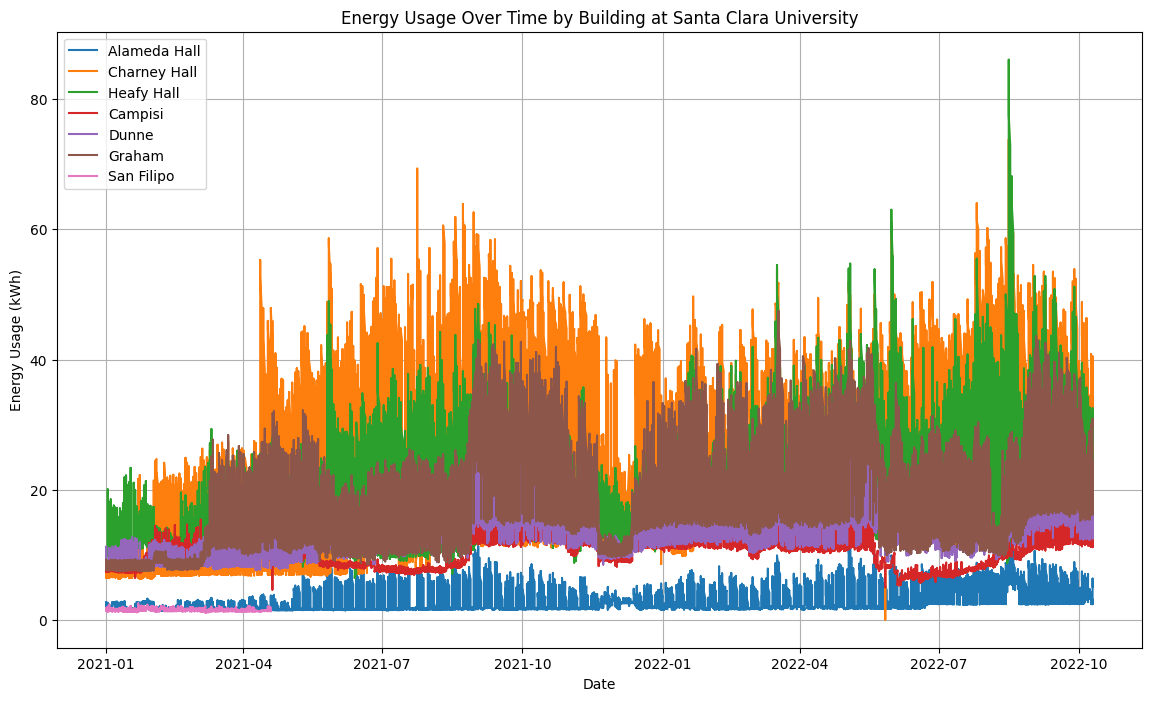

In [3]:
'''
From https://www.scu.edu/sustainability/about/datahub/operations/energy/energy-trends/, in 2022:
    - the energy use per person @ SCU was 9,085.203175 kWh
    - the energy use per sqft @ SCU was 23.826678 kWh/sqft
    - the total grid purchased energy was 73,035,948.326549 kWh

Load data:
    - buildings: alameda, charney, heafey, campisi, dunne, graham, san filipo
    - date range: 1/1/2021 (all) — 4/19/2021 (san filipo), 10/10/2022 (rest)
        - ~4 months of usage data for san filipo
        - ~2 years of usage data for all the rest of the buildings
    - measurements: each row records the energy usage of the building in kWh for that given hour
    - sqft-age:
        - alameda: 18,999 sqft
        - charney: 89,000 sqft
        - heafey: 42,458 sqft
        - campisi: 43,642 sqft
        - dunne: 61,227 sqft
        - graham: 125,000 sqft
        - san filipo: 39,742 sqft


'''

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
file_path = '../data/scu-load-data.csv'
scu_data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
scu_data['Date'] = pd.to_datetime(scu_data['Date'])

# Set the 'Date' as the index for easier plotting
scu_data.set_index('Date', inplace=True)

# Create a figure and set its size
plt.figure(figsize=(14, 8))

# Loop through each building column, except for the first three columns which are Month, Day, and Year
for column in scu_data.columns[3:]:  # This assumes that the first three columns are not building data
    plt.plot(scu_data.index, scu_data[column], label=column)

# Add a title and labels to the axes
plt.title('Energy Usage Over Time by Building at Santa Clara University')
plt.xlabel('Date')
plt.ylabel('Energy Usage (kWh)')

# Add a legend to the plot to identify each line
plt.legend()

# Display grid lines on the plot
plt.grid(True)

# Save the plot
plt.savefig('../figures/energy-usage-ot-all-loads.png')

# Show the plot
plt.show()



### Cumulative and Comparisons Between Academic and Residence

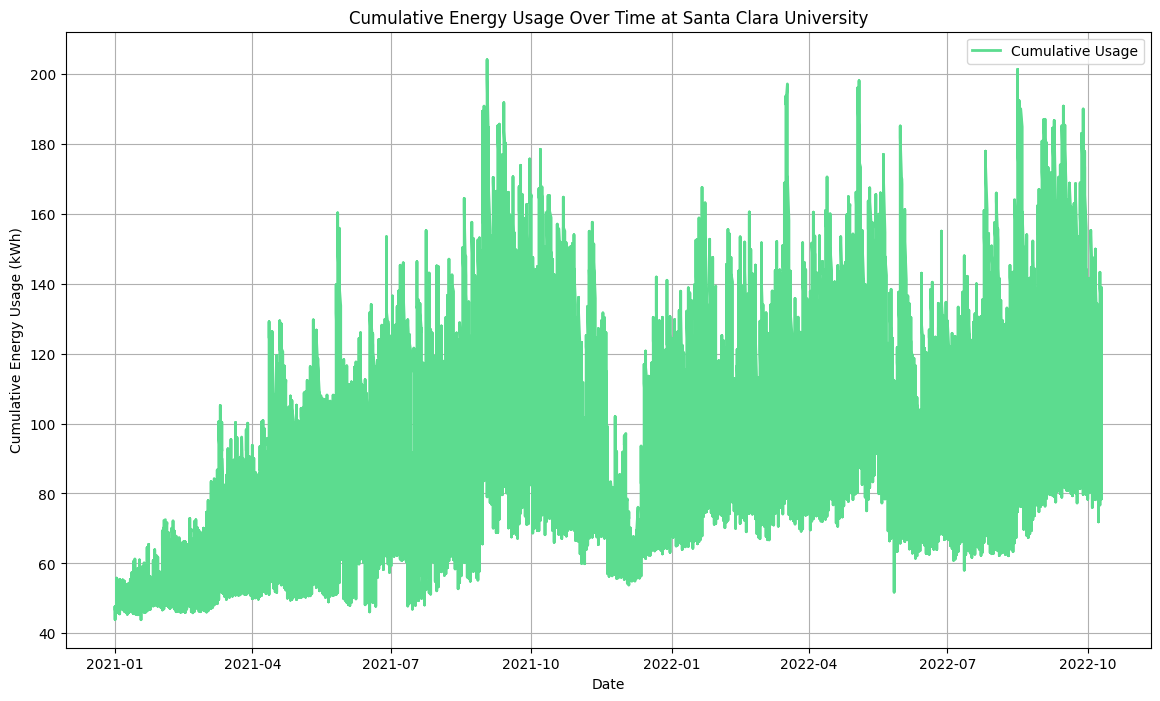

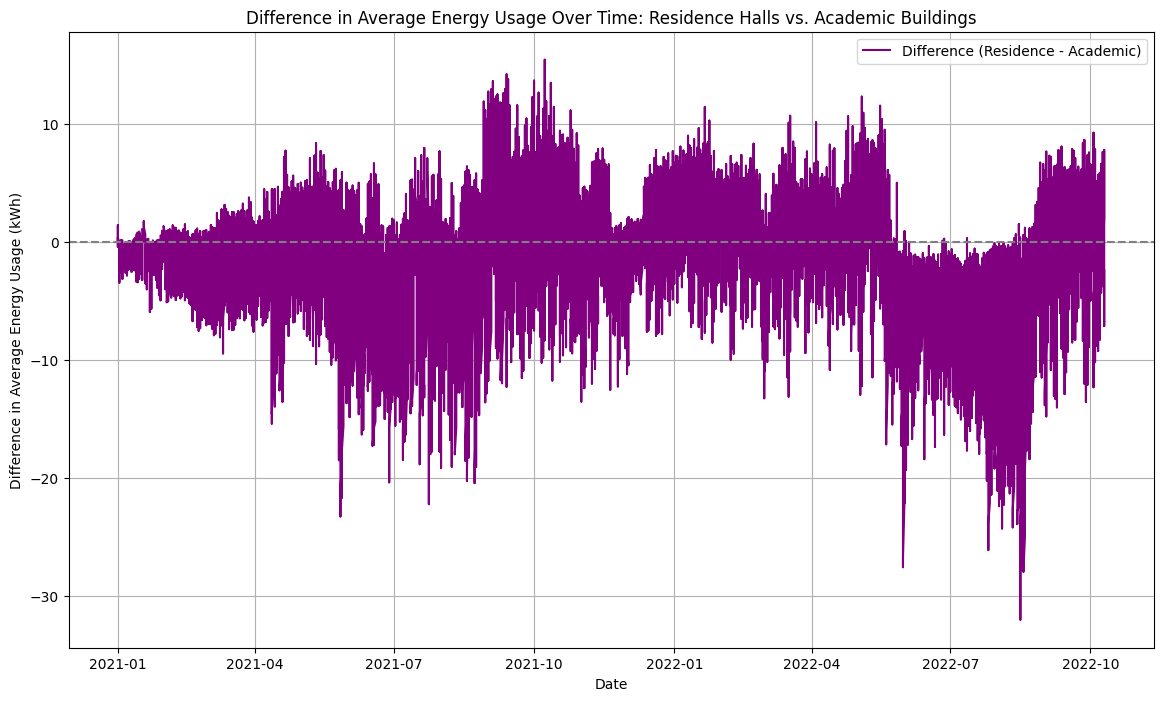

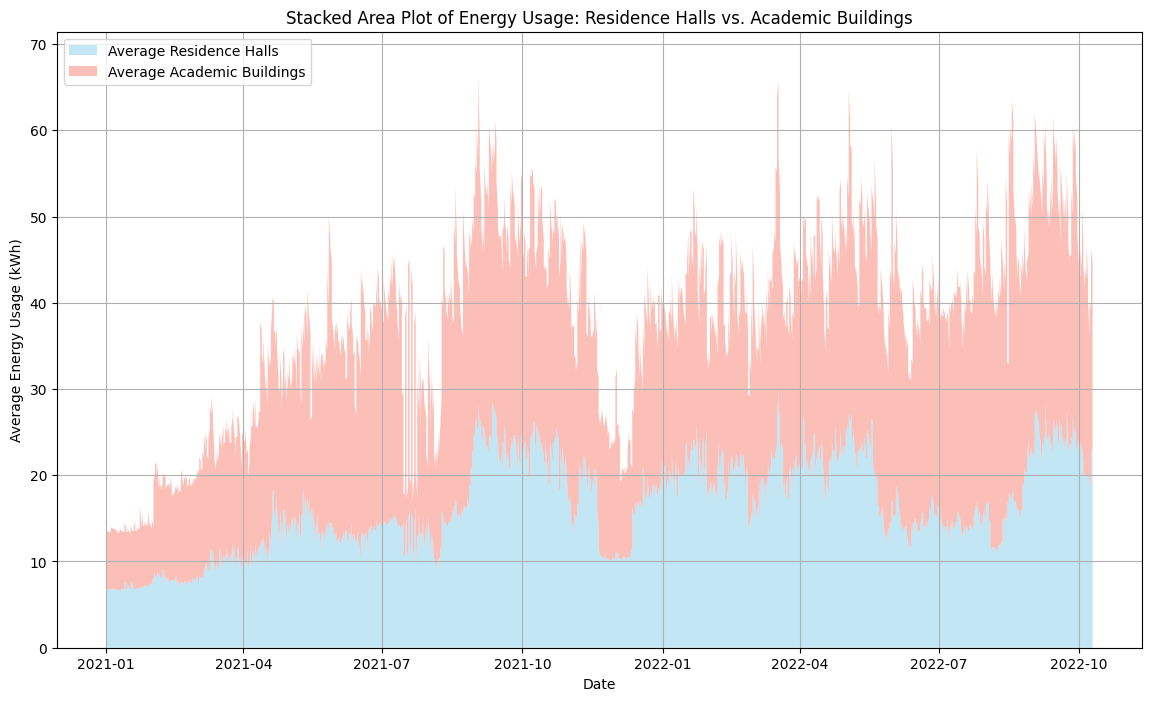

In [4]:
# Create a cumulative plot for all buildings
plt.figure(figsize=(14, 8))
scu_data['Cumulative Usage'] = scu_data.iloc[:, 3:].sum(axis=1)  # Sum across all building columns
plt.plot(scu_data.index, scu_data['Cumulative Usage'], label='Cumulative Usage', color='#5CDC8F', linewidth=2)

plt.title('Cumulative Energy Usage Over Time at Santa Clara University')
plt.xlabel('Date')
plt.ylabel('Cumulative Energy Usage (kWh)')
plt.legend()
plt.grid(True)
plt.savefig('../figures/energy-usage-ot-cumulative.png')
plt.show()

# Calculate average energy usage for residence halls vs. academic buildings
residence_halls = ['Campisi', 'Dunne', 'Graham', 'San Filipo']
academic_buildings = ['Alameda Hall', 'Charney Hall', 'Heafy Hall']

scu_data['Avg Residence Halls'] = scu_data[residence_halls].mean(axis=1)
scu_data['Avg Academic Buildings'] = scu_data[academic_buildings].mean(axis=1)

# Calculate the difference in average energy usage
scu_data['Difference in Avg Usage'] = scu_data['Avg Residence Halls'] - scu_data['Avg Academic Buildings']

# Plot the difference
plt.figure(figsize=(14, 8))
plt.plot(scu_data.index, scu_data['Difference in Avg Usage'], label='Difference (Residence - Academic)', color='purple')
plt.axhline(0, color='gray', linestyle='--')  # Zero line for reference
plt.title('Difference in Average Energy Usage Over Time: Residence Halls vs. Academic Buildings')
plt.xlabel('Date')
plt.ylabel('Difference in Average Energy Usage (kWh)')
plt.legend()
plt.grid(True)
plt.savefig('../figures/energy-usage-diff-res-acdmc.png')
plt.show()

# Create a stacked area plot
plt.figure(figsize=(14, 8))
plt.stackplot(scu_data.index, scu_data['Avg Residence Halls'], scu_data['Avg Academic Buildings'], 
              labels=['Average Residence Halls', 'Average Academic Buildings'], colors=['skyblue', 'salmon'], alpha=0.5)

plt.title('Stacked Area Plot of Energy Usage: Residence Halls vs. Academic Buildings')
plt.xlabel('Date')
plt.ylabel('Average Energy Usage (kWh)')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('../figures/energy-usage-area-res-acdmc.png')
plt.show()



### Heatmaps for Average Daily Usage by Month

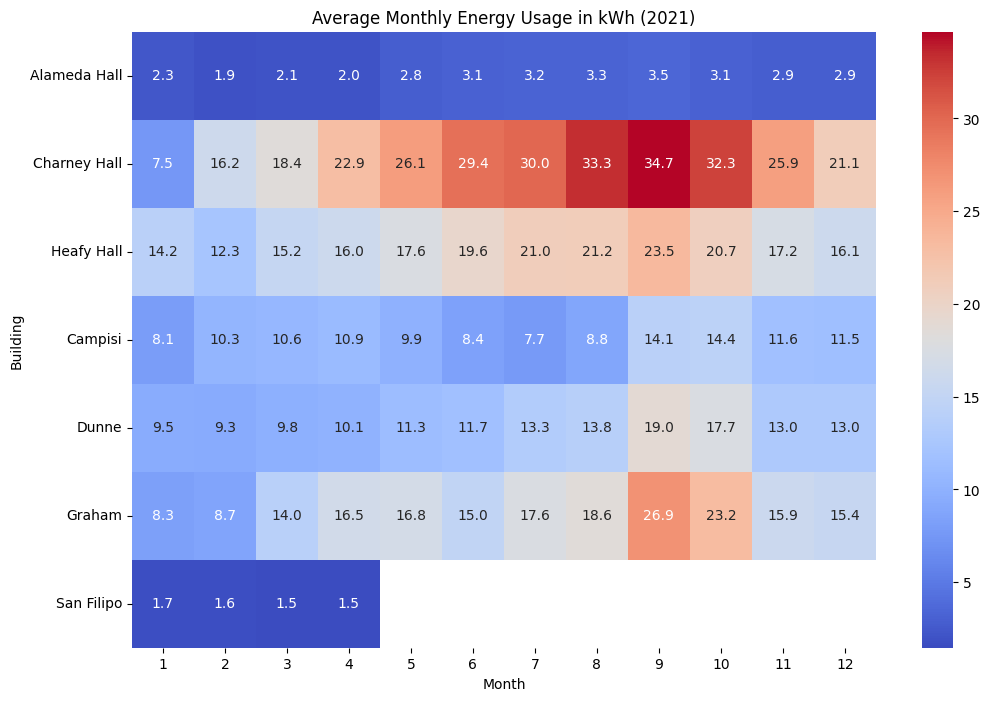

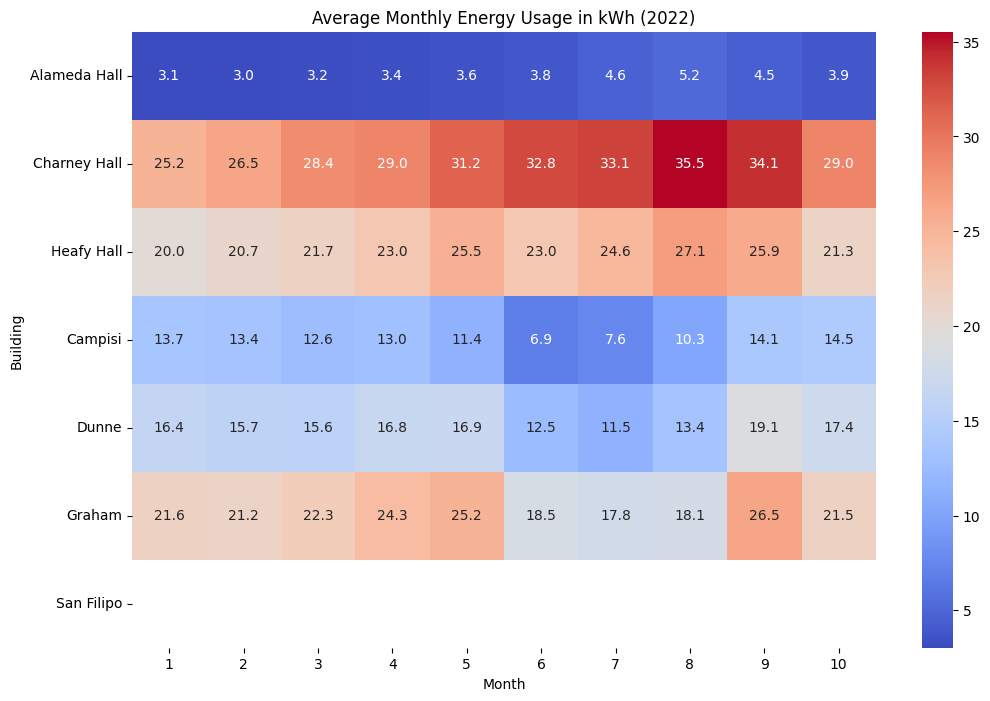

In [5]:
import seaborn as sns

# Extract year and month from the Date for grouping
scu_data['Year'] = scu_data.index.year
scu_data['Month'] = scu_data.index.month

# Group data by Year, Month, and calculate the mean for each building
monthly_data = scu_data.groupby(['Year', 'Month']).mean()

# Preparing data for the heatmap
heatmap_data = monthly_data[academic_buildings + residence_halls].T  # Transpose to have buildings as rows and months as columns

# Create a heatmap for each year
# As the data might span multiple years, we'll create a heatmap for each year separately
years = monthly_data.index.get_level_values(0).unique()

# Plotting
for year in years:
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data.loc[:, year], annot=True, fmt=".1f", cmap="coolwarm", cbar=True)
    plt.title(f'Average Monthly Energy Usage in kWh ({year})')
    plt.xlabel('Month')
    plt.ylabel('Building')
    plt.savefig('../figures/energy-usage-heatmap-by-load.png')
    plt.show()

### Box Plots

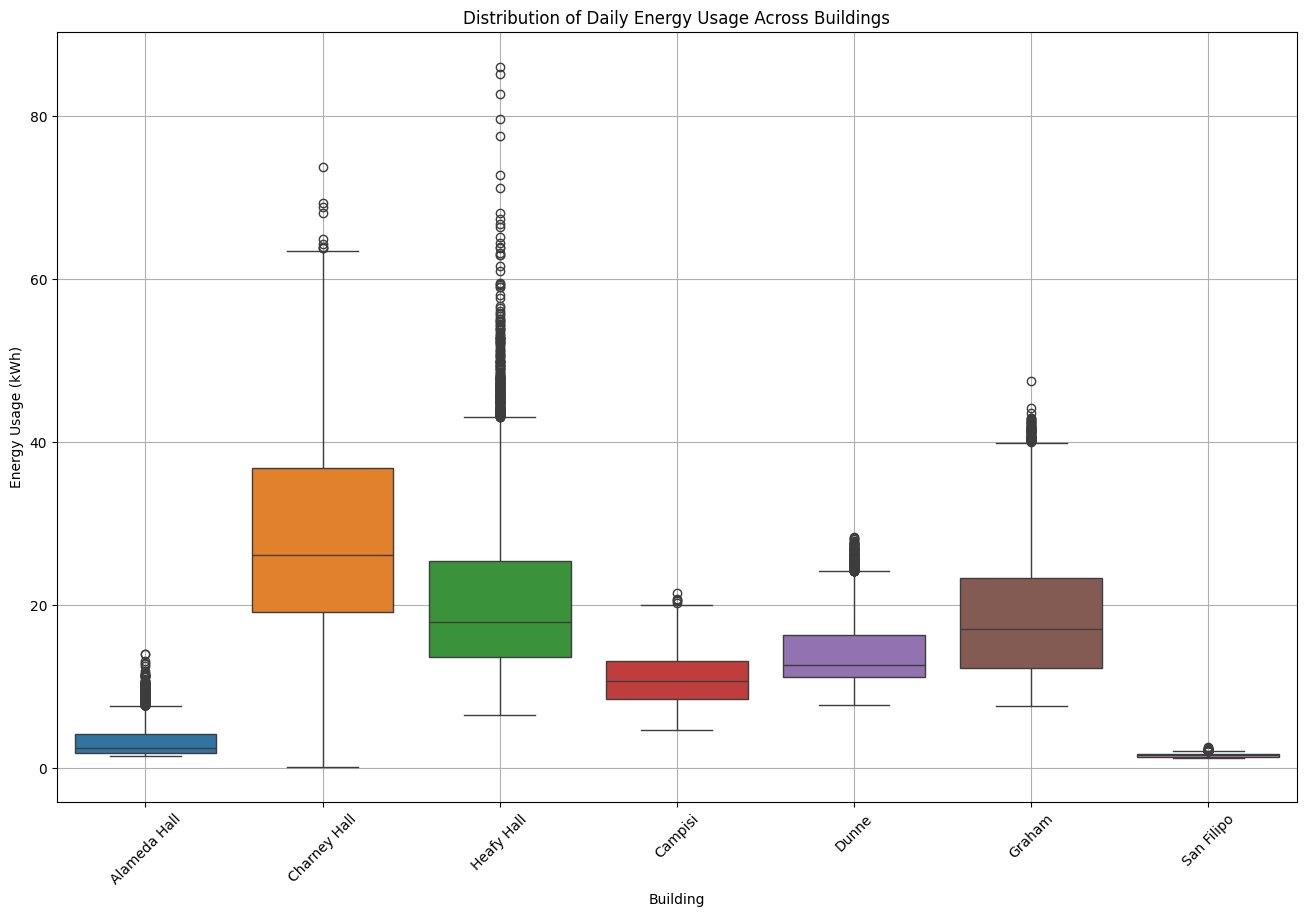

In [6]:
# Data is the DataFrame containing daily energy usage data for each building
# academic_buildings and residence_halls are lists of column names for these building types

plt.figure(figsize=(16, 10))
box_plot = sns.boxplot(data=scu_data[academic_buildings + residence_halls])
plt.title('Distribution of Daily Energy Usage Across Buildings')
plt.ylabel('Energy Usage (kWh)')
plt.xlabel('Building')
plt.xticks(rotation=45)  # Rotate building names for better readability
plt.grid(True)
# Adding median value annotations
for i, artist in enumerate(box_plot.artists):
    # Each 'artist' corresponds to a box in the box plot
    line = artist.lines[5]  # Median line is the 6th line in the artist (0-indexed)
    median_value = line.get_ydata()[0]  # Get median value, which is y position of the median line
    # Place the annotation text in the middle of the box with slight offset for readability
    text_x = artist.get_xdata()[1] - 0.05  # Middle of the box minus a small offset
    text_y = median_value + 0.5  # Just above the median line
    plt.text(text_x, text_y, f'{median_value:.2f}', fontsize=9, ha='center', va='bottom', color='black')
plt.savefig('../figures/energy-usage-box-plots.png')
plt.show()

### Correlation Analysis

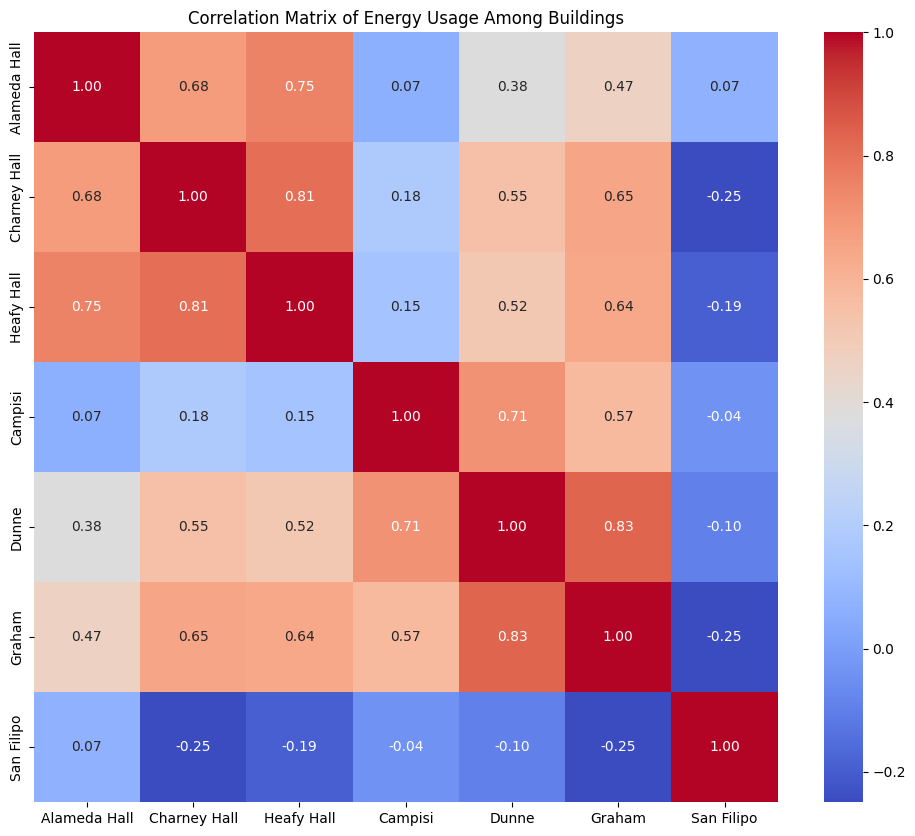

In [7]:
# Calculate the correlation matrix for the buildings
correlation_matrix = scu_data[academic_buildings + residence_halls].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Energy Usage Among Buildings')
plt.savefig('../figures/energy-usage-correlations.png')
plt.show()

### Seasonal Analysis

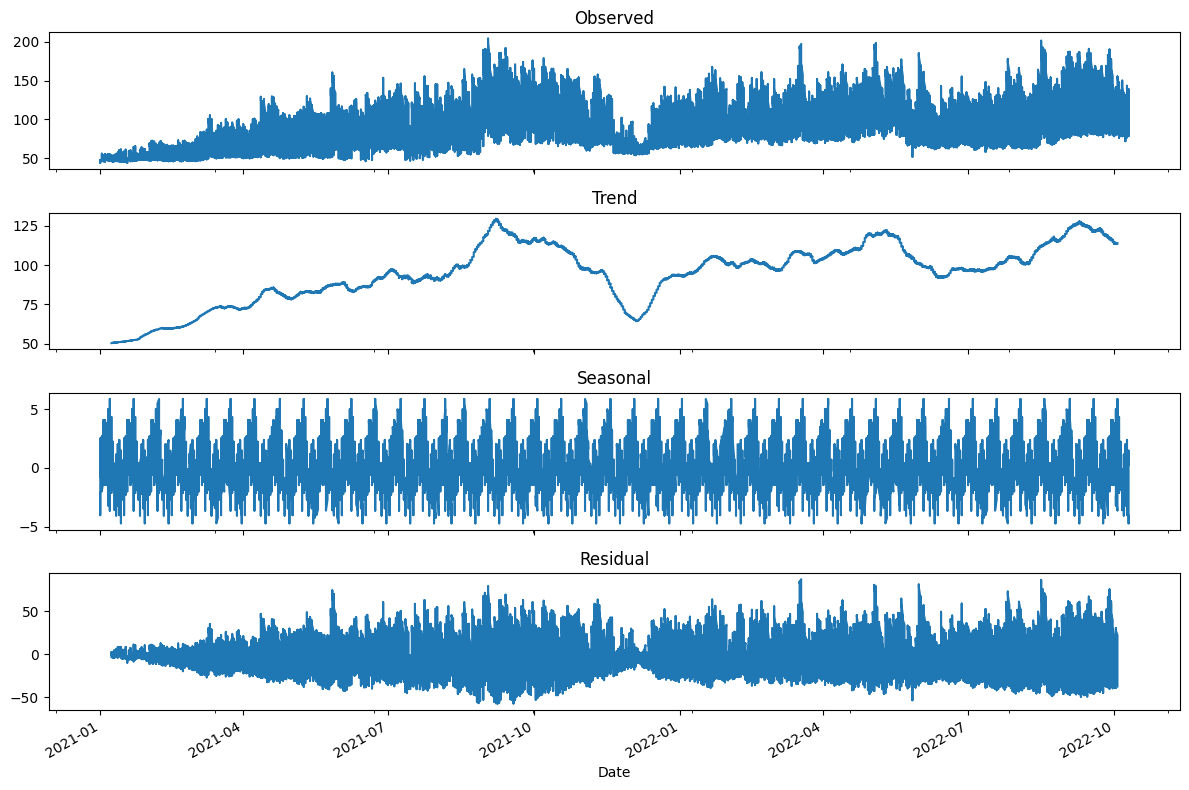

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Calculate cumulative daily energy usage
scu_data['Total Daily Usage'] = scu_data[academic_buildings + residence_halls].sum(axis=1)

# Decompose the total daily energy usage time series
decomposition = seasonal_decompose(scu_data['Total Daily Usage'], model='additive', period=365)

# Plot the seasonal decomposition
plt.figure(figsize=(12, 8))
# Define the layout of the subplots
layout = (4, 1)  # 4 rows, 1 column
# Plot the original data
ax1 = plt.subplot2grid(layout, (0, 0))
decomposition.observed.plot(ax=ax1, title='Observed')
# Plot the trend
ax2 = plt.subplot2grid(layout, (1, 0), sharex=ax1)
decomposition.trend.plot(ax=ax2, title='Trend')
# Plot the seasonal component
ax3 = plt.subplot2grid(layout, (2, 0), sharex=ax1)
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
# Plot the residuals
ax4 = plt.subplot2grid(layout, (3, 0), sharex=ax1)
decomposition.resid.plot(ax=ax4, title='Residual')
# Improve spacing between plots
plt.tight_layout()
# Save the figure if needed
plt.savefig('../figures/energy-usage-seasonal-analysis.png', dpi=300)
# Show the plot
plt.show()

### Clustering

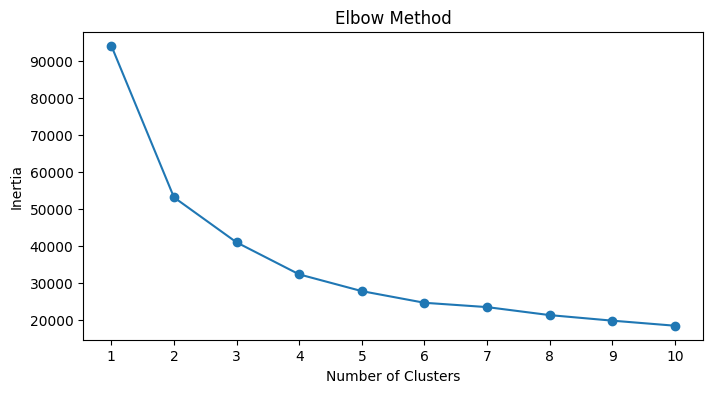

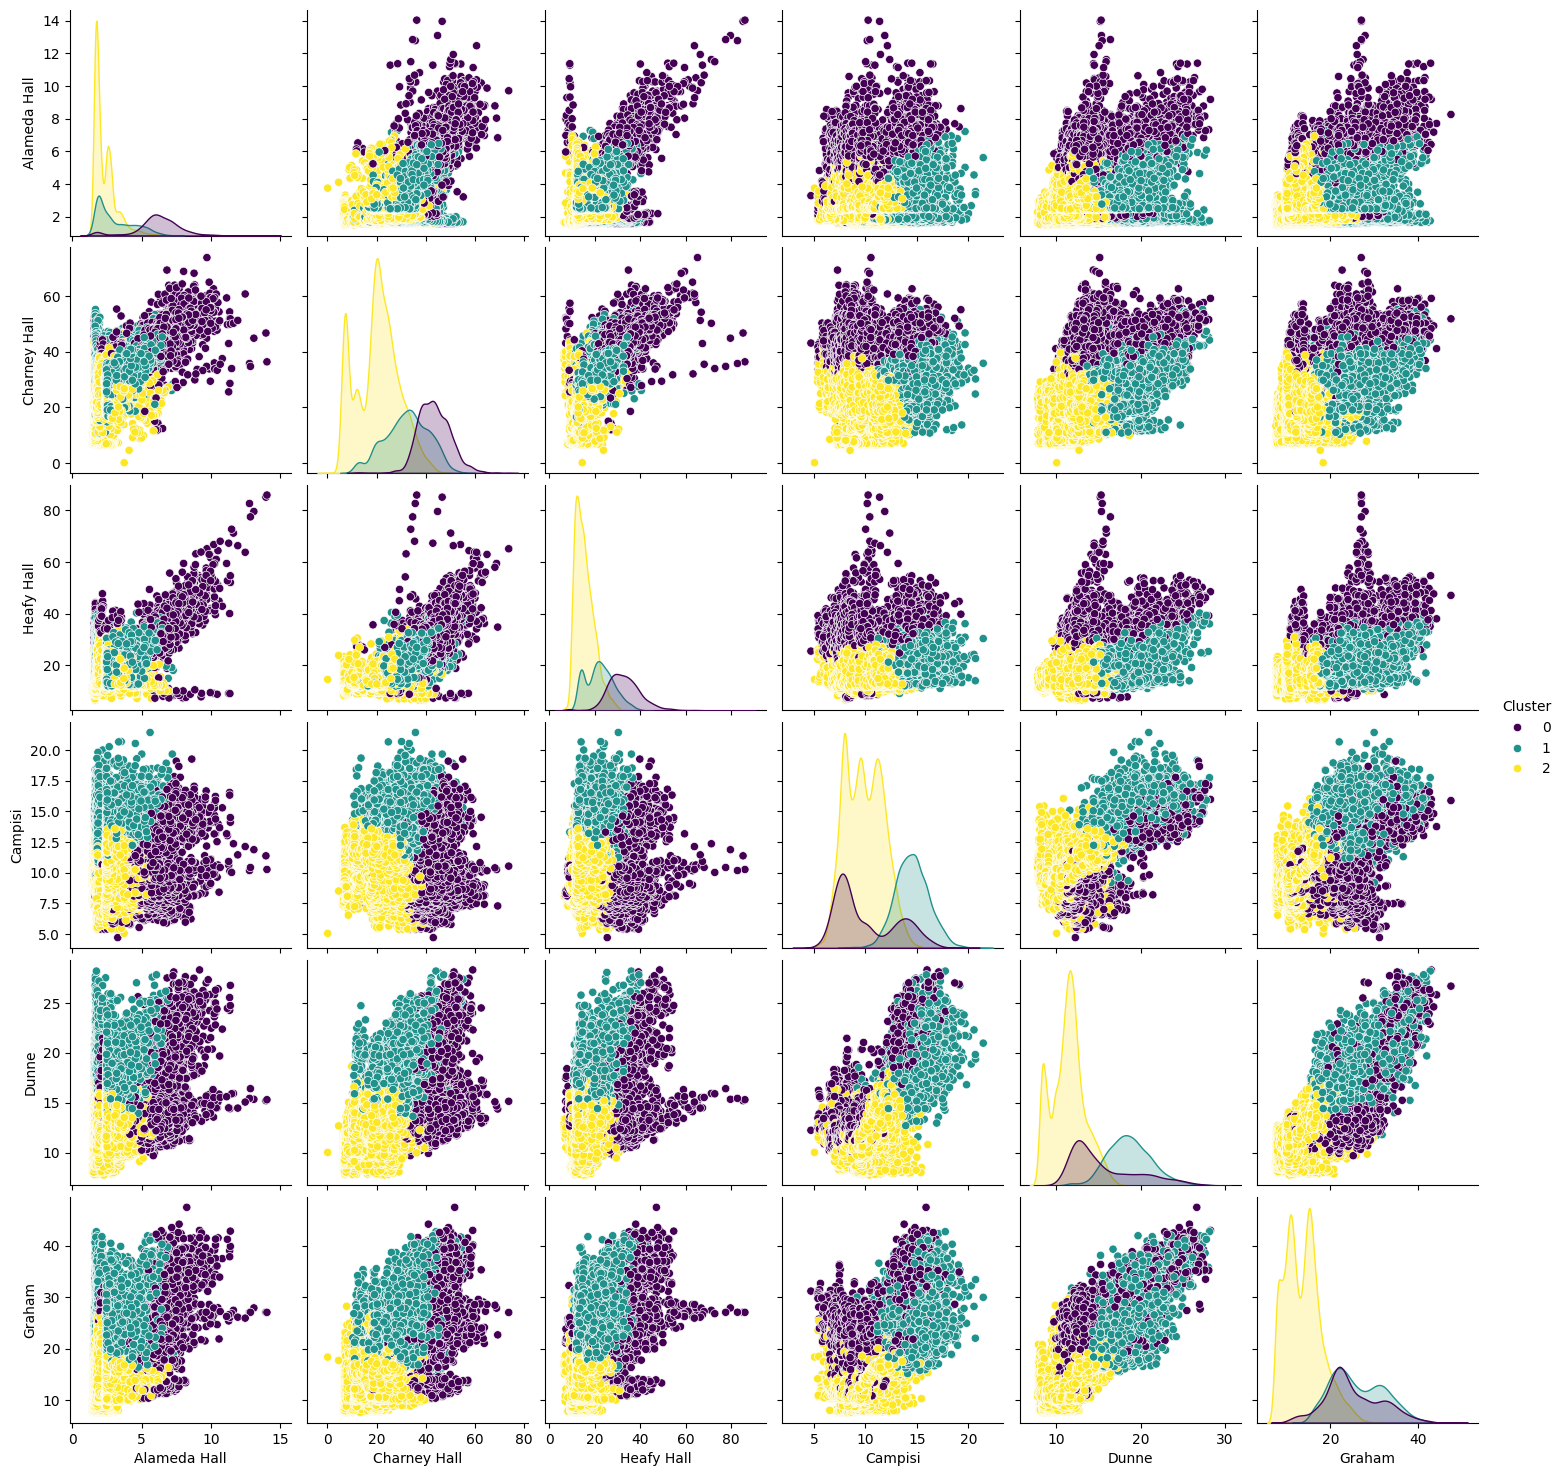

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming scu_data is your DataFrame with energy usage data for buildings
buildings = ['Alameda Hall', 'Charney Hall', 'Heafy Hall', 'Campisi', 'Dunne', 'Graham']
# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(scu_data[buildings])

# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, '-o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

# Assuming the optimal number of clusters is chosen based on the elbow method
optimal_clusters = 3  # Replace with the actual optimal number from your elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster assignments back to the original DataFrame
scu_data['Cluster'] = clusters

# Visualizing the clusters using pairplot
sns.pairplot(scu_data, vars=buildings, hue='Cluster', palette='viridis')
plt.savefig('../figures/energy-usage-clusters.png')
plt.show()

### Anomaly Detection

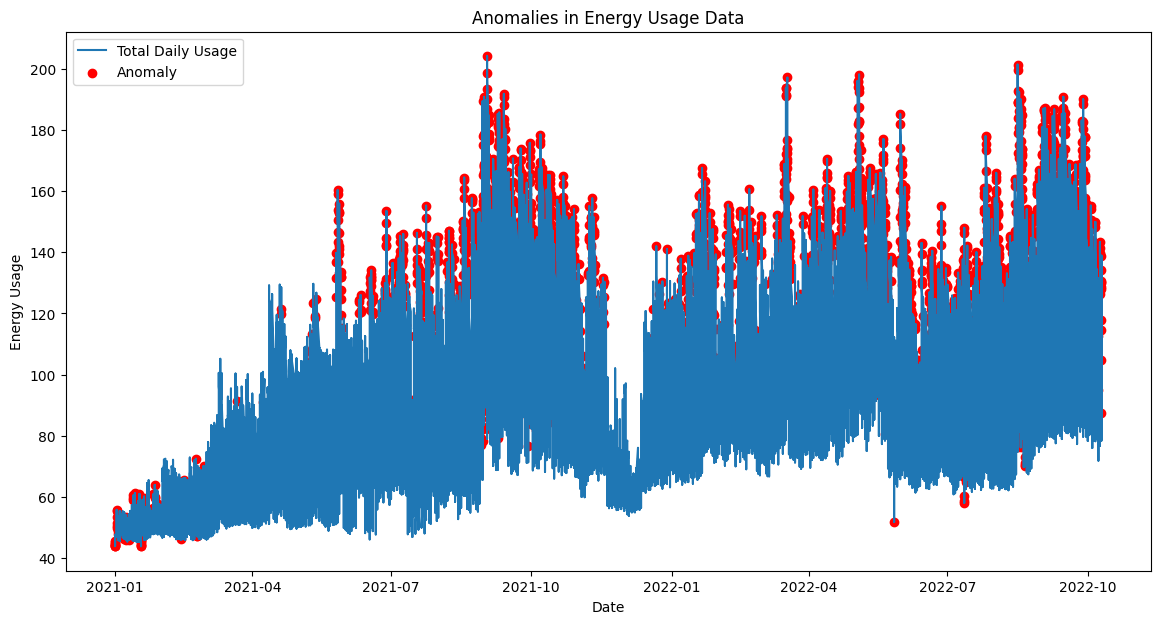

In [21]:
from sklearn.ensemble import IsolationForest

# Assuming scu_data is your DataFrame with the energy usage data

# Fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(scu_data[buildings])

# Predict anomalies
# The model returns -1 for outliers and 1 for inliers
anomalies = iso_forest.predict(scu_data[buildings])

# Add the anomalies to the data frame for investigation
scu_data['Anomaly'] = anomalies

# Filter the anomalies for review
anomalous_data = scu_data[scu_data['Anomaly'] == -1]

# Now let's plot the 'Total Daily Usage' with the anomalies marked
plt.figure(figsize=(14, 7))
plt.plot(scu_data.index, scu_data['Total Daily Usage'], label='Total Daily Usage')
plt.scatter(anomalous_data.index, anomalous_data['Total Daily Usage'], color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('Anomalies in Energy Usage Data')
plt.legend()
plt.savefig('../figures/energy-usage-anomaly-detection.png')
plt.show()


### Contribution Analysis

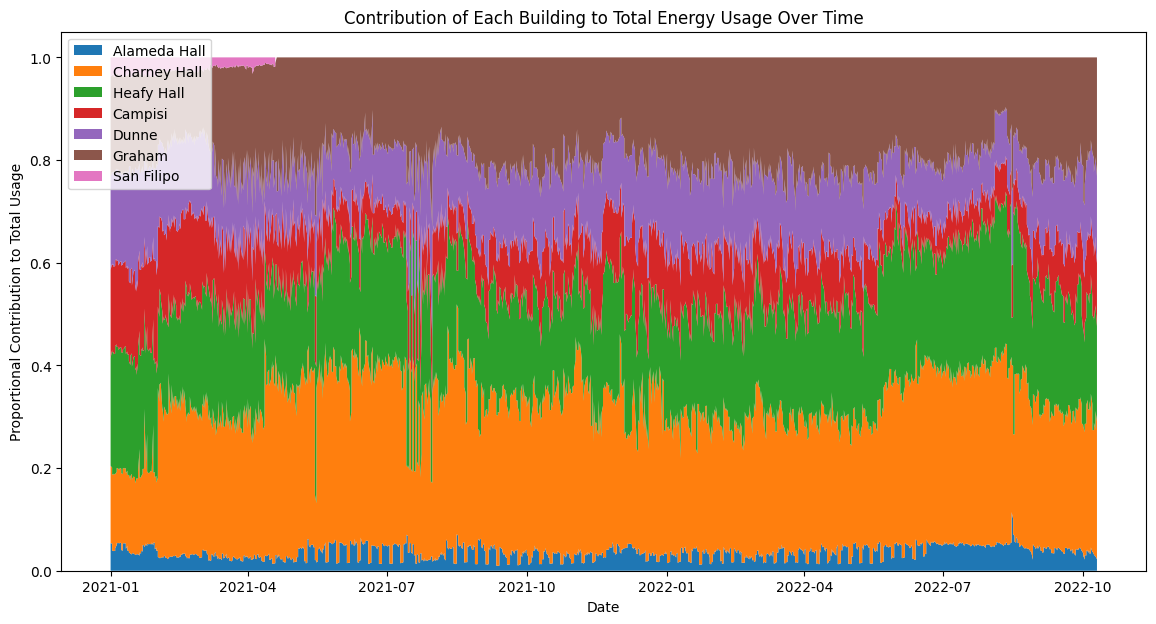

In [22]:
# Assuming scu_data is your DataFrame with energy usage data for buildings

# Step 1: Calculate the total daily energy usage if not already done
scu_data['Total Daily Usage'] = scu_data[academic_buildings + residence_halls].sum(axis=1)

# Step 2: Calculate the contribution of each building
building_contributions = scu_data[academic_buildings + residence_halls].div(scu_data['Total Daily Usage'], axis=0)

# Visualization: Create a stacked area plot showing the contribution over time
plt.figure(figsize=(14, 7))
plt.stackplot(scu_data.index, building_contributions.T, labels=building_contributions.columns)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Proportional Contribution to Total Usage')
plt.title('Contribution of Each Building to Total Energy Usage Over Time')
plt.savefig('../figures/energy-usage-contributions.png')
plt.show()

## Forecasting

### SARIMA (Don't use this!)

In [ ]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Auto parameter selection
model = auto_arima(scu_data['Total Daily Usage'], seasonal=True, m=12)

# Fit SARIMA model
sarima_model = SARIMAX(scu_data['Total Daily Usage'], order=model.order, seasonal_order=model.seasonal_order)
sarima_results = sarima_model.fit()

In [ ]:
import matplotlib.pyplot as plt

# Assuming `sarima_results` is your fitted model
# Forecasting the next N steps; let's assume N=30
forecast = sarima_results.get_forecast(steps=30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Dates for the forecast
dates = pd.date_range(start=scu_data.index[-1], periods=30, freq='D')

# Plotting actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(scu_data.index, scu_data['Total Daily Usage'], label='Actual Usage')
plt.plot(dates, mean_forecast, color='red', label='Forecasted Usage')

# Plotting the confidence intervals
plt.fill_between(dates, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.savefig('../figures/energy-usage-forecast-sarima.png')
plt.show()

### LSTM (Use this!)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Assuming scu_data is already sorted by date
total_size = len(scu_data)
train_size = int(total_size * 0.70)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

# Create the splits
train_data = scu_data.iloc[:train_size]
validation_data = scu_data.iloc[train_size:train_size + val_size]
test_data = scu_data.iloc[train_size + val_size:]

# Example output
print(f"Training data: {train_data.shape[0]} samples")
print(f"Validation data: {validation_data.shape[0]} samples")
print(f"Test data: {test_data.shape[0]} samples")

# Setting the window size
window_size = 30

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Here `i + window_size` is the index of the value to predict, and `i:i + window_size` are the input sequence indices
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Normalizing the data
scaler = MinMaxScaler()
scaler.fit(train_data[['Total Daily Usage']])
train_scaled = scaler.transform(train_data[['Total Daily Usage']])
validation_scaled = scaler.transform(validation_data[['Total Daily Usage']])
test_scaled = scaler.transform(test_data[['Total Daily Usage']])

# Creating sequences
X_train, y_train = create_sequences(train_scaled, window_size)
X_val, y_val = create_sequences(validation_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Display shapes of the datasets
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(scu_data['Total Daily Usage'])

# Create sequences
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:(i + window)])
        y.append(data[i + window])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30)

# LSTM Model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)

## Microgrid Model

### Data Analysis and Processing

In [55]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Load the data from CSV files
wind_data = pd.read_csv('../data/data_wind.csv')
pv_data = pd.read_csv('../data/data_pv.csv')

# Preprocessing function
def preprocess_data(data, feature_cols, target_col, sequence_length):
    # Handle missing data
    data = data.fillna(method='ffill')  # Forward fill
    
    # Normalize features and target
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[feature_cols + [target_col]])
    
    # Create sequences for LSTM input
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i, :-1])  # Features
        y.append(data_scaled[i, -1])  # Target
    return np.array(X), np.array(y), scaler

# Define feature and target columns
feature_cols_wind = ['Wind Speed (m/s)', 'Wind Direction (°)']
target_col_wind = 'ActivePower (kW)'
feature_cols_pv = pv_data.columns.difference(['generated_power_kw']).tolist()
target_col_pv = 'generated_power_kw'

# Preprocess both datasets
sequence_length = 24  # Using the last 24 hours of data
X_wind, y_wind, scaler_wind = preprocess_data(wind_data, feature_cols_wind, target_col_wind, sequence_length)
X_pv, y_pv, scaler_pv = preprocess_data(pv_data, feature_cols_pv, target_col_pv, sequence_length)

# Model creation function
def create_compile_model(input_shape, lstm_units, output_units=1, optimizer='adam', loss='mean_squared_error'):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape),
        Dense(output_units)
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Create models for wind and solar
model_wind = create_compile_model(input_shape=(X_wind.shape[1], X_wind.shape[2]), lstm_units=50)
model_pv = create_compile_model(input_shape=(X_pv.shape[1], X_pv.shape[2]), lstm_units=100)

# Summary of models (optional, for insight into the model structure)
model_wind.summary()
model_pv.summary()

/var/folders/4b/br7t5gk95cz067f6l2np3t6m0000gn/T/ipykernel_8111/1196272699.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/4b/br7t5gk95cz067f6l2np3t6m0000gn/T/ipykernel_8111/1196272699.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               48400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                

#### Solar Forecasting

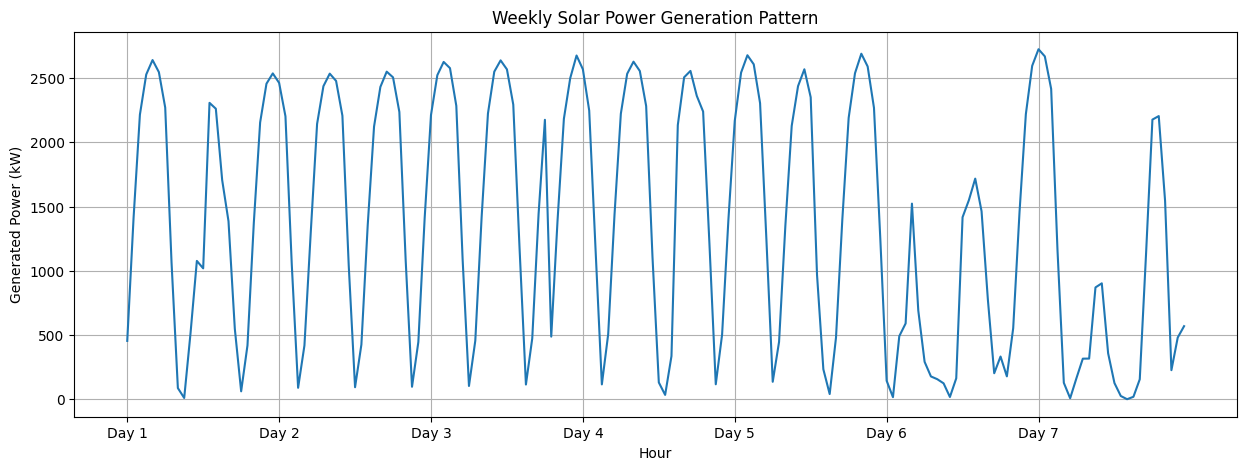

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'generated_power_kw' is loaded into pv_data DataFrame
daily_pattern = pv_data['generated_power_kw'].head(24*7)  # Look at one week of data

plt.figure(figsize=(15, 5))
plt.plot(daily_pattern)
plt.title('Weekly Solar Power Generation Pattern')
plt.xlabel('Hour')
plt.ylabel('Generated Power (kW)')
plt.xticks(ticks=np.arange(0, 24*7, 24), labels=[f"Day {i+1}" for i in range(7)])  # Label days on the x-axis
plt.grid(True)
plt.show()

In [90]:
import numpy as np
from pymgrid import Microgrid
from pymgrid.modules import BatteryModule, LoadModule, RenewableModule, GridModule

# Load data
load_data = pd.read_csv('../data/aggregated_hourly_total.csv')
pv_data = pd.read_csv('../data/data_pv.csv')
wind_data = pd.read_csv('../data/data_wind.csv')

# Creating a grid time series with import price, export price, CO2 production, and grid status
grid_time_series = np.array([[0.2, 0.1, 0.5, 1]] * (24*90))  # Example for 90 days at hourly intervals
solar_time_series = pv_data['generated_power_kw'].values
wind_time_series = wind_data['ActivePower (kW)'].abs().values 
load_time_series = load_data['total_hourly_usage'].values

# # Setting up the modules
# # Preparing the renewable modules with actual time series data
# solar = RenewableModule(time_series=solar_time_series)
# wind = RenewableModule(time_series=wind_time_series)
# battery = BatteryModule(min_capacity=0, max_capacity=200, max_charge=100, max_discharge=100, efficiency=0.95, init_soc=0.5)
# load = LoadModule(time_series=load_time_series)
# grid = GridModule(max_import=150, max_export=150, time_series=grid_time_series)  # Set grid limits based on utility rules

# # Creating the microgrid
# microgrid = Microgrid([("pv", solar), ("wind", wind), battery, load, grid])

# # Optional: Customize microgrid control strategies here

# # Example of running the microgrid simulation
# for j in range(10):
#     action = microgrid.sample_action(strict_bound=False)
#     microgrid.step(action)

# # Output the log of operations
# log = microgrid.get_log(drop_singleton_key=True)
# print(log)


In [93]:
# Standardizing lengths
len_pv = len(solar_time_series)
standard_length = len_pv  # Using the PV data length as the standard for simplicity

# Trim the load and wind data
load_data_trimmed = load_data.iloc[:standard_length]
wind_data_trimmed = wind_data.iloc[:standard_length]

# Extend the PV data by repeating it
pv_data_extended = np.tile(pv_data['generated_power_kw'].values, int(np.ceil(standard_length / len_pv)))[:standard_length]

# Update the grid time series to match the new standard length
grid_time_series = np.tile(np.array([[0.2, 0.1, 0.5, 1]]), (standard_length, 1))

In [98]:
print(pv_data_extended[:365].sum())

402379.90626423


### Microgrid Model

In [95]:
from pymgrid import Microgrid
from pymgrid.modules import BatteryModule, LoadModule, RenewableModule, GridModule
import numpy as np

# Assuming the extended and trimmed data has been prepared as described
# Trimmed load and wind data, extended PV data, and adjusted grid time series

# Setting up the modules
solar = RenewableModule(time_series=pv_data_extended)
wind = RenewableModule(time_series=wind_data_trimmed['ActivePower (kW)'].abs().values)
battery = BatteryModule(min_capacity=0, max_capacity=500, max_charge=100, max_discharge=100, efficiency=0.95, init_soc=0.5)
load = LoadModule(time_series=load_data_trimmed['total_hourly_usage'].values)
grid = GridModule(max_import=150, max_export=150, time_series=grid_time_series)

# Creating the microgrid with updated components
microgrid = Microgrid([("pv", solar), ("wind", wind), battery, load, grid])

In [96]:
# Optional: Setup a control strategy for the microgrid, if needed
# Here we use a simple loop to simulate microgrid operations

# Initialize or reset the microgrid to start conditions
microgrid.reset()

# Run simulation for each hour (or time step)
for j in range(len(pv_data_extended)):  # using the length of the extended data
    action = microgrid.sample_action(strict_bound=False)  # Sample an action based on the current state
    microgrid.step(action)  # Perform the action

# Collect and print logs to analyze
log = microgrid.get_log(drop_singleton_key=True)
print(log)


module_name balancing                                 battery                 \
field       loss_load overgeneration     reward charge_amount current_charge   
0                 0.0       0.000000  -0.000000     99.424448     100.000000   
1                 0.0       0.000000  -0.000000      5.838710     194.453226   
2                 0.0      19.253488 -38.506977      0.000000     200.000000   
3                 0.0       0.000000  -0.000000      0.000000     200.000000   
4                 0.0       0.000000  -0.000000      0.000000     200.000000   
...               ...            ...        ...           ...            ...   
4208              0.0      24.338544 -48.677087     29.227326      83.156258   
4209              0.0       0.000000  -0.000000     24.317815     110.922218   
4210              0.0       0.000000  -0.000000      0.000000     134.024142   
4211              0.0      40.222966 -80.445931      0.000000      57.373111   
4212              0.0       0.000000  -0

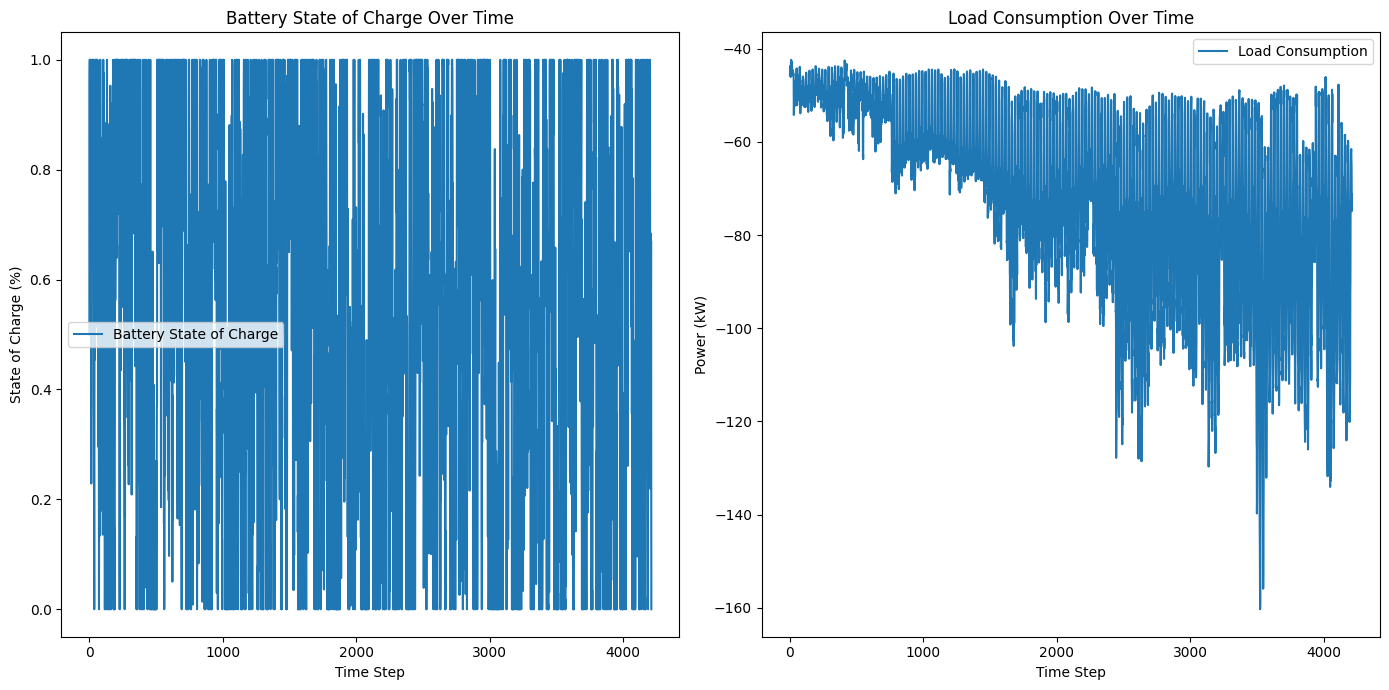

In [97]:
import matplotlib.pyplot as plt

# Assuming 'microgrid' is your Microgrid instance and the simulation has been run
log = microgrid.get_log(drop_singleton_key=True)

# Accessing data from a multi-indexed DataFrame
battery_soc = log[('battery', 'soc')]
load_current = log[('load', 'load_current')]

# Plotting the State of Charge of the battery and Load over time
plt.figure(figsize=(14, 7))

# Plotting battery state of charge
plt.subplot(1, 2, 1)
plt.plot(battery_soc, label='Battery State of Charge')
plt.title('Battery State of Charge Over Time')
plt.xlabel('Time Step')
plt.ylabel('State of Charge (%)')
plt.legend()

# Plotting load current
plt.subplot(1, 2, 2)
plt.plot(load_current, label='Load Consumption')
plt.title('Load Consumption Over Time')
plt.xlabel('Time Step')
plt.ylabel('Power (kW)')
plt.legend()

plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data from CSV files
wind_data = pd.read_csv('../data/data_wind.csv')
pv_data = pd.read_csv('../data/data_pv.csv')

# Preprocessing function
def preprocess_data(data, feature_cols, target_col, sequence_length):
    # Handle missing data
    data = data.fillna(method='ffill')  # Forward fill
    
    # Normalize features and target
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[feature_cols + [target_col]])
    
    # Create sequences for LSTM input
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i, :-1])  # Features
        y.append(data_scaled[i, -1])  # Target
    return np.array(X), np.array(y), scaler

# Define feature and target columns
feature_cols_wind = ['Wind Speed (m/s)', 'Wind Direction (°)']
target_col_wind = 'ActivePower (kW)'
feature_cols_pv = pv_data.columns.difference(['generated_power_kw']).tolist()
target_col_pv = 'generated_power_kw'

# Preprocess both datasets
sequence_length = 24  # Using the last 24 hours of data
X_wind, y_wind, scaler_wind = preprocess_data(wind_data, feature_cols_wind, target_col_wind, sequence_length)
X_pv, y_pv, scaler_pv = preprocess_data(pv_data, feature_cols_pv, target_col_pv, sequence_length)

# Model creation function
def create_compile_model(input_shape, lstm_units, output_units=1, optimizer='adam', loss='mean_squared_error'):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape),
        Dense(output_units)
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Create models for wind and solar
model_wind = create_compile_model(input_shape=(X_wind.shape[1], X_wind.shape[2]), lstm_units=50)
model_pv = create_compile_model(input_shape=(X_pv.shape[1], X_pv.shape[2]), lstm_units=100)

# Summary of models (optional, for insight into the model structure)
model_wind.summary()
model_pv.summary()

# Splitting data into training and validation sets
X_temp_pv, X_test_pv, y_temp_pv, y_test_pv = train_test_split(X_pv, y_pv, test_size=0.2, random_state=42)
X_train_pv, X_val_pv, y_train_pv, y_val_pv = train_test_split(X_temp_pv, y_temp_pv, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

X_temp_wind, X_test_wind, y_temp_wind, y_test_wind = train_test_split(X_wind, y_wind, test_size=0.2, random_state=42)
X_train_wind, X_val_wind, y_train_wind, y_val_wind = train_test_split(X_temp_wind, y_temp_wind, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Setting up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Function to create, compile, and train the model with a given learning rate
def train_model_with_lr(X_train, y_train, X_val, y_val, learning_rate):
    model = create_compile_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        lstm_units=100,
        optimizer=Adam(learning_rate=learning_rate)
    )
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  # Set verbose to 1 if you want to see the progress
    )
    return model, history

/var/folders/4b/br7t5gk95cz067f6l2np3t6m0000gn/T/ipykernel_8111/2534027844.py:16: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/4b/br7t5gk95cz067f6l2np3t6m0000gn/T/ipykernel_8111/2534027844.py:16: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10600     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               48400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                              

In [61]:
import tensorflow as tf

pv_model = tf.keras.models.load_model('../models/solar-forecast.keras')
wind_model = tf.keras.models.load_model('../models/wind-forecast.keras')

27/27 [==============================] - 1s 3ms/step
Test MAE: 1144.1863
Test RMSE: 1319.3864


/Users/xava/Documents/ams/auto-grid/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



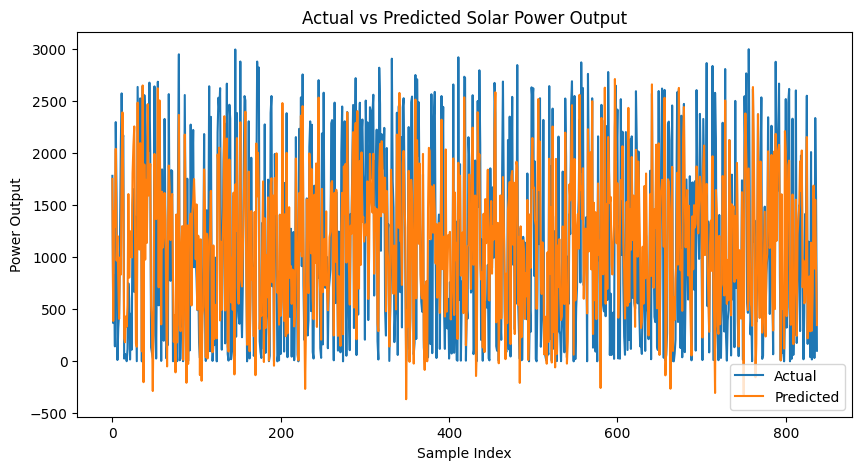

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Since we only want to inverse transform the target variable, we create a dummy array
# that has the same number of features as during fitting.
# We'll then replace the last column of this array with our scaled target variable.

# The number of columns should be the same as during fitting the scaler
num_columns = scaler_pv.scale_.shape[0]

# Create a dummy array where all columns are zeros
dummy_array = np.zeros((y_test_pv.shape[0], num_columns))

# Replace the last column of the dummy array with the scaled target variable
dummy_array[:, -1] = y_test_pv

# Now we can safely inverse transform the dummy array
y_test_pv_rescaled = scaler_pv.inverse_transform(dummy_array)[:, -1]

# Predict on test data
y_pred_test_scaled = pv_model.predict(X_test_pv)

# Create an array with the correct shape to inverse scale our predictions
# We're assuming that the scaler was fit to the data with all features present, hence the need for the correct number of columns
num_features = scaler_pv.scale_.shape[0]  # This should match the number of features the scaler was fit on
dummy_array = np.zeros((y_pred_test_scaled.shape[0], num_features))

# Place the predictions in the appropriate column (assuming the target is the last column after all features)
dummy_array[:, -1] = y_pred_test_scaled[:, 0]

# Inverse transform to get predictions back to original scale
y_pred_test = scaler_pv.inverse_transform(dummy_array)[:, -1]

# Calculate performance metrics
mae = mean_absolute_error(y_test_pv, y_pred_test)
rmse = mean_squared_error(y_test_pv, y_pred_test, squared=False)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Visualizing the predicted vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_pv_rescaled, label='Actual')
plt.plot(y_pred_test, label='Predicted')
plt.title('Actual vs Predicted Solar Power Output')
plt.xlabel('Sample Index')
plt.ylabel('Power Output')
plt.legend()
plt.show()

316/316 [==============================] - 1s 2ms/step
Test MAE: 1332.2689
Test RMSE: 1749.0636


/Users/xava/Documents/ams/auto-grid/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



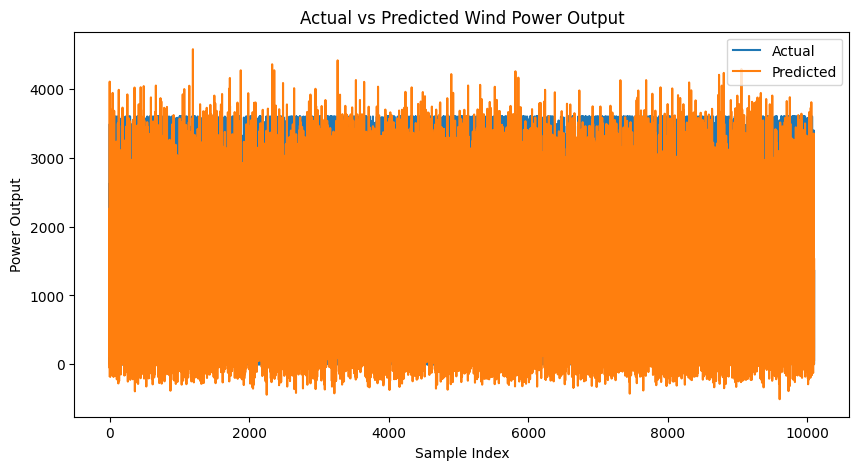

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Since we only want to inverse transform the target variable, we create a dummy array
# that has the same number of features as during fitting.
# We'll then replace the last column of this array with our scaled target variable.

# The number of columns should be the same as during fitting the scaler
num_columns = scaler_wind.scale_.shape[0]

# Create a dummy array where all columns are zeros
dummy_array = np.zeros((y_test_wind.shape[0], num_columns))

# Replace the last column of the dummy array with the scaled target variable
dummy_array[:, -1] = y_test_wind

# Now we can safely inverse transform the dummy array
y_test_wind_rescaled = scaler_wind.inverse_transform(dummy_array)[:, -1]

# Predict on test data
y_pred_test_scaled = wind_model.predict(X_test_wind)

# Create an array with the correct shape to inverse scale our predictions
# We're assuming that the scaler was fit to the data with all features present, hence the need for the correct number of columns
num_features = scaler_wind.scale_.shape[0]  # This should match the number of features the scaler was fit on
dummy_array = np.zeros((y_pred_test_scaled.shape[0], num_features))

# Place the predictions in the appropriate column (assuming the target is the last column after all features)
dummy_array[:, -1] = y_pred_test_scaled[:, 0]

# Inverse transform to get predictions back to original scale
y_pred_test = scaler_wind.inverse_transform(dummy_array)[:, -1]

# Calculate performance metrics
mae = mean_absolute_error(y_test_wind, y_pred_test)
rmse = mean_squared_error(y_test_wind, y_pred_test, squared=False)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Visualizing the predicted vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_wind_rescaled, label='Actual')
plt.plot(y_pred_test, label='Predicted')
plt.title('Actual vs Predicted Wind Power Output')
plt.xlabel('Sample Index')
plt.ylabel('Power Output')
plt.legend()
plt.show()

In [87]:
load_data = pd.read_csv('../data/scu-load-data.csv')

# Exclude 'San Filipo' and any non-energy columns from the DataFrame
energy_data = load_data[['Alameda Hall', 'Charney Hall', 'Heafy Hall', 'Campisi', 'Dunne', 'Graham']]

# Sum across the selected columns to get total energy usage per entry
load_data['total_hourly_usage'] = energy_data.sum(axis=1)

load_data[['total_hourly_usage']].to_csv('aggregated_hourly_total.csv')

# Display the first few rows to check the totals and provide statistics for verification
load_data[['total_hourly_usage']].head(), load_data['total_hourly_usage'].describe()


(   total_hourly_usage
 0           45.729010
 1           43.743110
 2           43.780941
 3           44.271235
 4           44.946671,
 count    15667.000000
 mean        94.497393
 std         31.156320
 min         42.408846
 25%         70.295156
 50%         88.184027
 75%        116.800588
 max        204.091806
 Name: total_hourly_usage, dtype: float64)